<a href="https://colab.research.google.com/github/sriharisivashanmugam/BlowerFault/blob/main/Blower_Fault_v2_Jan_12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

For every heater, regardless of period of data available, do feature engineering, normalize them temporally by period of data available and have 2 clusters faulty/non-fauly, analyze the two clusters for significant differences and try predicting new heaters in the clusters.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import os

In [2]:
def had_fault(data):
  if 'E1.0' in set(data['ErrorCode']):
    return True
  else:
    return False

def number_of_unique_faults(data):
  data['lag_error'] = data['ErrorCode'].shift(1)
  return data[(data['ErrorCode']=='E1.0') & (data['lag_error']!='E1.0')].shape[0]

def get_stats(data):
  if had_fault(data)==True:
    data['lag'] = data['ErrorCode'].shift(1)
    end = int(data[(data['ErrorCode']=='E1.0') & (data['lag']!='E1.0')].index[0])
    data = data.iloc[0:end+1,:]
  mean_pwm = data['BlowerPWM'].mean()
  mean_rpm = data['BlowerRPM'].mean()
  mean_fr = data['FiringRate'].mean()
  mean_ft = data['FlueTemperature'].mean()
  max_pwm = data['BlowerPWM'].max()
  max_rpm = data['BlowerRPM'].max()
  max_fr = data['FiringRate'].max()
  max_ft = data['FlueTemperature'].max()

  return mean_pwm,mean_rpm,mean_fr,mean_ft,max_pwm,max_rpm,max_fr,max_ft

def get_agg(data):
  pass


In [3]:
new_df = {'HEX':[],'mean_pwm':[],'mean_rpm':[],'mean_fr':[],'mean_ft':[],'max_pwm':[],'max_rpm':[],'max_fr':[],'max_ft':[],'had_fault':[]}
for i in os.listdir('/content/drive/MyDrive/Predictive Models/Blower Fault Phase 2/Hex_with_blowerFault-training/Hex_with_blowerFault/'):
  temp = pd.read_csv('/content/drive/MyDrive/Predictive Models/Blower Fault Phase 2/Hex_with_blowerFault-training/Hex_with_blowerFault/'+i)
  temp = temp[['BlowerPWM','BlowerRPM','FiringRate','FlueTemperature','ErrorCode']]

  new_df['HEX'].append(i.split('.')[0])
  res = get_stats(temp)
  # print(i,had_fault(temp),number_of_unique_faults(temp),res)
  # print(i)
  new_df['mean_pwm'].append(res[0])
  new_df['mean_rpm'].append(res[1])
  new_df['mean_fr'].append(res[2])
  new_df['mean_ft'].append(res[3])
  new_df['max_pwm'].append(res[4])
  new_df['max_rpm'].append(res[5])
  new_df['max_fr'].append(res[6])
  new_df['max_ft'].append(res[7])
  new_df['had_fault'].append(had_fault(temp))

new_df = pd.DataFrame(new_df)

In [4]:
new_df = new_df[new_df['max_rpm']>0]

In [5]:
new_df.describe()

,mean_pwm,mean_rpm,mean_fr,mean_ft,max_pwm,max_rpm,max_fr,max_ft
count,39.000000,39.000000,39.000000,39.000000,39.000000,39.000000,39.000000,39.000000
mean,230.640365,6206.135789,15.050409,102.146530,356.153846,8476.769231,197.333333,126.794872
std,59.133195,1071.456876,11.485131,8.430361,30.357986,368.423916,65.698808,9.597641
min,113.595178,4118.827813,0.000000,83.000000,293.000000,7597.000000,0.000000,83.000000
25%,189.194474,5483.285174,5.940104,95.527897,345.500000,8333.500000,155.000000,123.000000
50%,237.119023,6162.978292,15.471253,103.184695,353.000000,8366.000000,234.000000,127.000000
75%,272.967454,7144.616034,20.676717,109.379103,364.500000,8624.000000,251.000000,133.000000
max,316.604897,7788.624666,51.747328,114.187443,450.000000,9425.000000,251.000000,142.000000


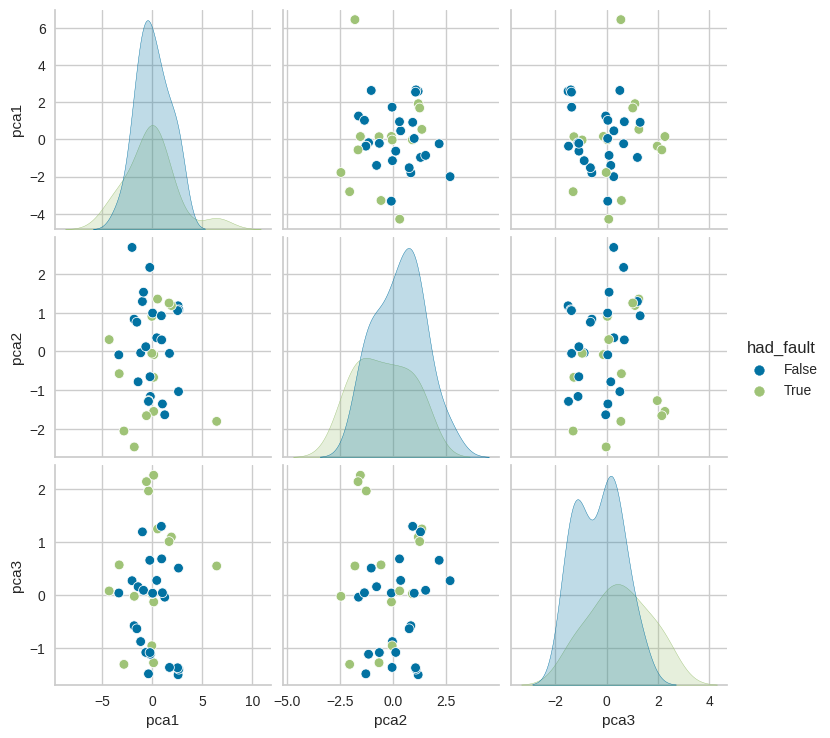

In [43]:
sns.pairplot(new_df,hue='had_fault')

In [25]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()

X = new_df.iloc[:,1:-1]
Y = new_df.iloc[:,-1]

ss_df = ss.fit_transform(X)

In [26]:
pca = PCA(n_components=3)
pc = pca.fit_transform(ss_df)

p_df = pd.DataFrame(pc, columns = ['pca1','pca2','pca3'])

In [27]:
final_df = pd.concat([p_df,Y],axis=1)

In [32]:
import plotly.express as px

px.scatter_3d(final_df,x='pca1',y='pca2',z='pca3',color='had_fault')

In [ ]:
#pca

#normalize the features

#Build models

In [7]:
# pip install pycaret

In [36]:
from pycaret.classification import *
s = setup(final_df, target = 'had_fault', session_id = 124)

,Description,Value
0,Session id,124
1,Target,had_fault
2,Target type,Binary
3,Original data shape,"(39, 4)"
4,Transformed data shape,"(39, 4)"
5,Transformed train set shape,"(27, 4)"
6,Transformed test set shape,"(12, 4)"
7,Numeric features,3
8,Preprocess,True
9,Imputation type,simple


In [37]:
best = compare_models(sort='AUC')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
gbc,Gradient Boosting Classifier,0.6500,0.7500,0.5000,0.3500,0.4000,0.2300,0.2500,0.1280
dt,Decision Tree Classifier,0.6500,0.6500,0.6000,0.4333,0.4833,0.2900,0.3000,0.0260
ada,Ada Boost Classifier,0.5833,0.6000,0.3000,0.2000,0.2333,0.0400,0.0500,0.1420
rf,Random Forest Classifier,0.5500,0.5000,0.2000,0.1000,0.1333,-0.0600,-0.0500,0.1890
lightgbm,Light Gradient Boosting Machine,0.6167,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0440
dummy,Dummy Classifier,0.6167,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0240
xgboost,Extreme Gradient Boosting,0.3833,0.4500,0.2000,0.1500,0.1667,-0.2500,-0.3000,0.0520
lr,Logistic Regression,0.6167,0.4000,0.2000,0.2000,0.2000,0.0500,0.0500,1.0050
nb,Naive Bayes,0.5500,0.4000,0.2000,0.1500,0.1667,-0.0600,-0.0500,0.0270
lda,Linear Discriminant Analysis,0.5833,0.4000,0.2000,0.2000,0.2000,0.0000,0.0000,0.0460


Processing:   0%|          | 0/65 [00:00<?, ?it/s]

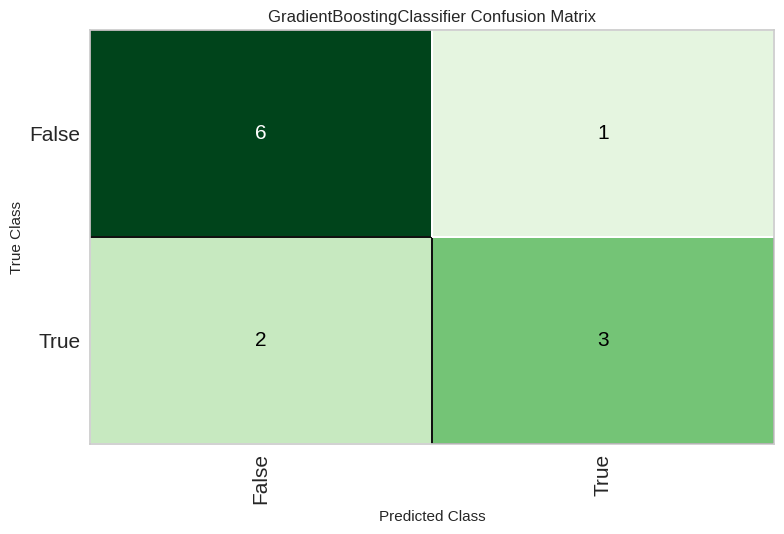

In [38]:
plot_model(best, plot = 'confusion_matrix')

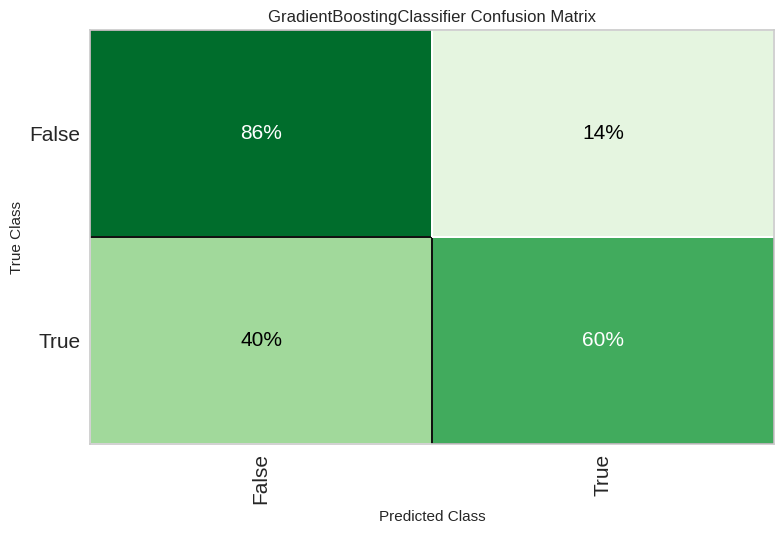

In [39]:
plot_model(best, plot = 'confusion_matrix',plot_kwargs={'percent':True})

In [40]:
predict_model(best)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Gradient Boosting Classifier,0.7500,0.5143,0.6000,0.7500,0.6667,0.4706,0.4781


,pca1,pca2,pca3,had_fault,prediction_label,prediction_score
0,-1.801162,0.832677,-0.578875,False,0,0.9879
14,0.141980,-0.666873,-1.280425,True,1,0.7630
12,2.661588,1.074230,-1.402936,False,0,0.9907
30,-0.363788,-1.267780,1.972088,True,0,0.9987
9,2.588557,1.176940,-1.507439,False,0,0.8912
3,1.256323,-1.633422,-0.038783,False,1,0.9998
18,1.919581,1.184637,1.100648,True,1,0.9869
22,1.730888,-0.050622,-1.368959,False,0,0.5294
26,-0.862001,1.528656,0.091329,False,0,0.9976
37,-0.213595,-0.651651,-1.087218,False,0,0.9967


In [41]:
evaluate_model(best)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

Testing the model

In [42]:
test_df = {'HEX':[],'mean_pwm':[],'mean_rpm':[],'mean_fr':[],'mean_ft':[],'max_pwm':[],'max_rpm':[],'max_fr':[],'max_ft':[],'had_fault':[]}
for i in os.listdir('/content/drive/MyDrive/Predictive Models/Blower Fault Phase 2/Hex_with_blowerFault/'):
  temp = pd.read_csv('/content/drive/MyDrive/Predictive Models/Blower Fault Phase 2/Hex_with_blowerFault/'+i)
  temp = temp[['BlowerPWM','BlowerRPM','FiringRate','FlueTemperature','ErrorCode']]

  test_df['HEX'].append(i.split('.')[0])
  res = get_stats(temp)
  # print(i)
  # print(i,had_fault(temp),number_of_unique_faults(temp),res)
  test_df['mean_pwm'].append(res[0])
  test_df['mean_rpm'].append(res[1])
  test_df['mean_fr'].append(res[2])
  test_df['mean_ft'].append(res[3])
  test_df['max_pwm'].append(res[4])
  test_df['max_rpm'].append(res[5])
  test_df['max_fr'].append(res[6])
  test_df['max_ft'].append(res[7])
  test_df['had_fault'].append(had_fault(temp))

test_df = pd.DataFrame(test_df)

KeyboardInterrupt: 

In [ ]:
test_df = test_df[~test_df['HEX'].isin(new_df['HEX'])]

In [ ]:
x = ss.tra

In [20]:
predictions = predict_model(best, data=test_df, raw_score=True)
predictions.head()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Logistic Regression,0.5000,0.4741,0.3529,0.3750,0.3636,-0.0475,-0.0476


,HEX,mean_pwm,mean_rpm,mean_fr,mean_ft,max_pwm,max_rpm,max_fr,max_ft,had_fault,prediction_label,prediction_score_0,prediction_score_1
0,iQ100110241866_HEX_1,149.373520,4469.896973,18.121126,93.062477,450.0,9315.0,251.0,142.0,False,0,0.9953,0.0047
1,iQ100110241866_HEX_2,148.425247,4301.081543,26.607134,87.274757,450.0,9191.0,254.0,129.0,True,0,0.7943,0.2057
3,iQ100110241866_HEX_4,151.003601,4259.038574,22.586689,85.421715,450.0,9258.0,251.0,155.0,True,0,0.9999,0.0001
16,iQ100106071844_HEX_1,283.410980,7068.105469,20.073776,107.388344,367.0,8342.0,251.0,144.0,True,0,0.9992,0.0008
20,iQ100106081845_HEX_1,217.098572,5873.388672,25.340630,112.004272,350.0,8345.0,196.0,137.0,True,0,0.9698,0.0302


In [21]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(predictions['had_fault'],predictions['prediction_label']))

[[30 20]
 [22 12]]
